# First steps with Leaspy

Welcome for the second practical session of the day!

### Objectives :
- Learn to use Leaspy methods


# The set-up

As before, if you have followed the [installation details](https://gitlab.com/icm-institute/aramislab/disease-course-mapping-solutions) carefully, you should

- be running this notebook in the `leaspy_tutorial` virtual environment
- having all the needed packages already installed

<span style='color: #a13203; font-weight: 600;'>💬 Question 1 💬</span> __Run the following command lines__

In [1]:
!pip install leaspy

In [2]:
!git clone https://gitlab.com/icm-institute/aramislab/disease-course-mapping-solutions.git

Cloning into 'disease-course-mapping-solutions'...
remote: Enumerating objects: 334, done.
remote: Counting objects: 100% (196/196), done.
remote: Compressing objects: 100% (125/125), done.
remote: Total 334 (delta 68), reused 196 (delta 68), pack-reused 138
Receiving objects: 100% (334/334), 38.85 MiB | 21.85 MiB/s, done.
Resolving deltas: 100% (110/110), done.


In [3]:
import os
from scipy import stats
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')
pd.options.display.float_format = '{:.4g}'.format

# import main classes from Leaspy package
from leaspy import Leaspy, Data, AlgorithmSettings, IndividualParameters, __watermark__
from leaspy.io.logs.visualization.plotting import Plotting

data_path = lambda *p: os.path.join('./disease-course-mapping-solutions/challenges/TP2_leaspy_beginner/data', *p)

# Watermark trace with all packages versions
__watermark__

{'leaspy': '1.2.0',
 'torch': '1.10.1',
 'numpy': '1.19.1',
 'pandas': '1.2.3',
 'scipy': '1.7.3',
 'sklearn': '0.23.1',
 'joblib': '0.14.1',
 'statsmodels': '0.13.1',
 'matplotlib': '3.2.2'}

# Part I: Data

<span style='color: #015e75; font-weight: 600;'>ℹ️ Information ℹ️</span> Data that can be used as a leaspy input should have the following format.

#### This result in multiple rows per subject. The input format **_MUST_** follow the following rules:
- A column named `ID`: corresponds to the subject indices
- A columns named `TIME`: corresponds to the subject's age at the corresponding visit
- One column per feature
- Each row is a visit, therefore the concatenation of the subject ID, the patient age at which the corresponding visit occurred, and then the feature values

#### Concerning the features' values, as we are using a logistic model, they **_MUST_**:
- Be between 0 and 1
- In average increase with time for each subject (normal states correspond to values near 0 and pathological states to values near 1)

Moreover, to calibrate the progression model, we highly recommend to keep subjects that have been seen at least two times. You probably noticed that there are NaN: do not worry, Leaspy can handle them ;)

<span style='color: #a13203; font-weight: 600;'>💬 Question 2 💬</span> __Run the following lines to load the data.__

In [4]:
df = pd.read_csv(data_path('simulated_data-corrected.csv'))
df = df.set_index(["ID","TIME"], verify_integrity=True).sort_index()
df.head()

MDS1_total  MDS2_total  MDS3_off_total  SCOPA_total  MOCA_total  \
ID     TIME                                                                     
GS-001 71.35      0.1123      0.1225          0.1711         0.16      0.2753   
       71.55      0.1409      0.1095          0.1187       0.1359      0.3809   
       72.05      0.2255      0.2705         0.06131       0.2111      0.3512   
       73.05      0.1325      0.2535          0.2588       0.2453      0.3778   
       73.55      0.2789      0.3219          0.1433       0.2231      0.2928   

              REM_total  PUTAMEN_R  PUTAMEN_L  CAUDATE_R  CAUDATE_L  PUTAMEN  
ID     TIME                                                                   
GS-001 71.35     0.4925     0.7802     0.6768     0.6226     0.4946   0.7285  
       71.55     0.5772     0.7514     0.7198     0.6184      0.531   0.7356  
       72.05     0.8358     0.8233     0.6915     0.7171      0.577   0.7574  
       73.05     0.5665     0.8136     0.7879       0.77     0.7095   0.8008  
       73.55     0.7418     0.8888     0.8527     0.7974     0.7155   0.8708

<span style='color: #a13203; font-weight: 600;'>💬 Question 3 💬</span> __Does the data set seem to have the good format?__


<span style='color: #a13203; font-weight: 600;'>💬 Question 4 💬</span> __How many patients are there in the dataset?__

In [5]:
n_subjects = df.index.get_level_values('ID').unique().shape[0]
print(f'{n_subjects} subjects in the dataset.')

200 subjects in the dataset.


<span style='color: #a13203; font-weight: 600;'>💬 Question 5 💬</span> __Create a training test that contains the first 160 patients and a testing set the rest. Each set will only contain the following features:__
- __MDS1_total__
- __MDS2_total__
- __MDS3_off_total__

Help : Be careful, one patient is not one line ...

In [6]:
df_train = df.loc[:'GS-160'][["MDS1_total", "MDS2_total", "MDS3_off_total"]]
df_test = df.loc['GS-161':][["MDS1_total", "MDS2_total", "MDS3_off_total"]]

### Leaspy's `Data` container


<span style='color: #015e75; font-weight: 600;'>ℹ️ Information ℹ️</span> _Leaspy_ comes with its own data containers. The one used in a daily basis is `Data`. You can load your data from a csv with it `Data.from_csv_file` or from a DataFrame `Data.from_dataframe`.

<span style='color: #a13203; font-weight: 600;'>💬 Question 6 💬</span> __Run the following lines to convert DataFrame into Data object.__

In [7]:
data_train = Data.from_dataframe(df_train)
data_test = Data.from_dataframe(df_test)

# Part II : Instantiate a `Leaspy` object

<span style='color: #015e75; font-weight: 600;'>ℹ️ Information ℹ️</span> Before creating a leaspy object, you need to choose the type of progression shape you want to give to your data. The available models are the following:
- linear
- logistic

with the possibility to enforce a _parallelism_ between the features. **_Parallelism_** imposes that all the features have the same average pace of progression.

Once that is done, you just have to call `Leaspy('model_name')`. The dedicated names are  :
- `univariate_linear`
- `linear`
- `univariate_logistic`
- `logistic`
- `logistic_parallel`
- `lme_model`
- `constant_model`

<span style='color: #a13203; font-weight: 600;'>💬 Question 7 💬</span> __We choose a logistic model. Run the following line to instantiate the leaspy object.__

In [8]:
leaspy = Leaspy("logistic",
                source_dimension=2,             # number of dimensions for non-temporal inter-subject variability
                noise_model='gaussian_diagonal' # estimate the residual noise scaling per feature
         )
leaspy_plotting = Plotting(leaspy.model)

/Users/p-e.poulet/opt/miniconda2/envs/aramis/lib/python3.8/site-packages/leaspy/io/logs/visualization/plotting.py:38: FutureWarning: Plotting will soon be removed from Leaspy, please use Plotter instead.
  warnings.warn('Plotting will soon be removed from Leaspy, please use Plotter instead.',


<span style='color: #015e75; font-weight: 600;'>ℹ️ Information ℹ️</span> `Leaspy` object contains all the main methods provided by the software. With this object, you can:
- **calibrate** a model
- **personalize** a model to individual data (basically you infer the random effects with a gradient descent)
- **estimate** the features values of subjects at given ages based on your calibrated model and their individual parameters
- **simulate** synthetic subjects base on your calibrated model, a collection of individual parameters and data
- **load** and **save** a model

<span style='color: #a13203; font-weight: 600;'>💬 Question 8 💬</span> __Check it out by running the following line__

In [9]:
? Leaspy

<span style='color: #a13203; font-weight: 600;'>💬 Question 9 💬</span> __This `Leaspy` object comes with an handy attribute for visualization. Let's have a look on the data that will be used to calibrate our model__

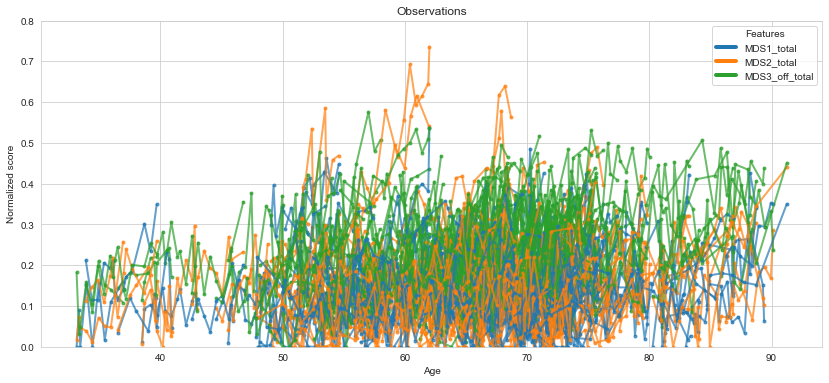

In [10]:
ax = leaspy_plotting.patient_observations(data_train, alpha=.7, figsize=(14, 6))
ax.set_ylim(0,.8)
plt.show()

Well... not so engaging, right? Let's see what Leaspy can do for you.

# Part III : Choose your algorithms

<span style='color: #015e75; font-weight: 600;'>ℹ️ Information ℹ️</span> Once you chose your model, you need to choose an algorithm to calibrate it.

To run any algorithm, you need to specify the settings of the related algorithm thanks to the `AlgorithmSettings` object. To ease Leaspy's usage for new users, we specified default values for each algorithm. Therefore, the name of the algorithm used is enough to run it. The one you need to fit your progression model is `mcmc_saem`, which stands for <a href="https://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo" target="_blank">Markov chain Monte Carlo</a> - Stochastic Approximation of <a href="https://en.wikipedia.org/wiki/Expectation%E2%80%93maximization_algorithm" target="_blank">Expectation Maximization</a>.

<span style='color: #a13203; font-weight: 600;'>💬 Question 10 💬</span> __Run the following line to instantiate a `AlgorithmSettings` object.__

In [11]:
algo_settings = AlgorithmSettings('mcmc_saem',
                                  n_iter=3000,           # n_iter defines the number of iterations
                                  seed=0)                # to make the calibration deterministic for reproducibility

<span style='color: #015e75; font-weight: 600;'>ℹ️ Information ℹ️</span> You can specify many more settings that are left by default for now. You can also save and load an `AlgorithmSettings` object in a json file.

<span style='color: #a13203; font-weight: 600;'>💬 Question 11 💬</span> __Run the following line to get more informations.__

In [12]:
? AlgorithmSettings

<span style='color: #015e75; font-weight: 600;'>ℹ️ Information ℹ️</span> It is often useful, even if it is optional to store the different logs of the model during the iterations. You can use the following method with the path of the folder where the logs will be stored.

<span style='color: #a13203; font-weight: 600;'>💬 Question 12 💬</span> __Run the following lines.__

In [13]:
algo_settings.set_logs(
    path='logs',          # Creates a logs file ; if existing, ask if rewrite it
    plot_periodicity=50,  # Saves the values to display in pdf every 50 iterations
    save_periodicity=10,  # Saves the values in csv files every 10 iterations
    console_print_periodicity=None,  # If = N, it display logs in the console/terminal every N iterations
    overwrite_logs_folder=True       # Default behaviour raise an error if the folder already exists.
)

/Users/p-e.poulet/opt/miniconda2/envs/aramis/lib/python3.8/site-packages/leaspy/io/settings/outputs_settings.py:94: UserWarning: The logs path you provided (/Users/p-e.poulet/Documents/Aramis/code/ai4health/disease-course-mapping-solutions/solutions/TP2_leaspy_beginner/logs) does not exist. Needed paths will be created (and their parents if needed).
  warnings.warn(f"The logs path you provided ({settings['path']}) does not exist. "


# Part IV : Fit your model

<span style='color: #a13203; font-weight: 600;'>💬 Question 13 💬</span> __Run the following lines to fit the model.__

In [14]:
leaspy.fit(data_train, settings=algo_settings)

 ==> Setting seed to 0
|##################################################|   3000/3000 iterations
Fit with `mcmc_saem` took: 5m 9s
The standard deviation of the noise at the end of the fit is:
MDS1_total: 5.10%
MDS2_total: 5.41%
MDS3_off_total: 6.50%


In [15]:
#leaspy = Leaspy.load('outputs/model_parameters.json')

<span style='color: #015e75; font-weight: 600;'>ℹ️ Information ℹ️</span> This might take several minutes, so let's discuss about the _keyword argument_ `source_dimension`. This parameters depend on the number of variable you want the model to learn: it can go from 1 to the number of variables. If it is not set by the user the default value is $\sqrt{N_{features}}$ as it has been shown empirically to give good results. You will learn more about the mathematical formulation of the model below (part V).

<span style='color: #015e75; font-weight: 600;'>ℹ️ Information ℹ️</span> Before assuming that the model is estimated, you have to check that the convergence went well. For that, you can look the at the convergence during the iterations. To do so, you can explore the `logs` folder (in the same folder than this jupyter notebook) that shows the model convergence during the iterations. The first thing to look at is probably the `plots/convergence_1.pdf` and `plots/convergence_2.pdf` files : a run has had enough iterations to converge if the last 20 or even 30% of the iterations were stable for all the parameters. If not, you should provably re-run it with more iterations.

We first need to import a library to display the PDF, so run the following cells :

In [16]:
from IPython.display import IFrame
IFrame('./logs/plots/convergence_1.pdf', width=990, height=670)

<span style='color: #a13203; font-weight: 600;'>💬 Question 14 💬</span> __Check out the parameters of the model that are stored here__

In [17]:
leaspy.model.parameters

{'g': tensor([1.8768, 1.8087, 1.2359]),
 'v0': tensor([-4.6532, -4.4626, -4.6422]),
 'betas': tensor([[-0.0327,  0.0011],
         [-0.0124, -0.0606]]),
 'tau_mean': tensor(66.1884),
 'tau_std': tensor(10.3833),
 'xi_mean': tensor(0.),
 'xi_std': tensor(0.6181),
 'sources_mean': tensor(0.),
 'sources_std': tensor(1.),
 'noise_std': tensor([0.0510, 0.0541, 0.0650])}

<span style='color: #015e75; font-weight: 600;'>ℹ️ Information ℹ️</span>  Parameters are probably not straightforward for now. The most important one is probably `noise_std`. It corresponds to the standard deviation of the Gaussian errors (one per feature). The smallest, the better - up to the lower bound which is the intrinsic noise in the data. Note that usually, cognitive measurements have an intrinsic error (computed on test-retest exams) between 5% and 10%.


<span style='color: #a13203; font-weight: 600;'>💬 Question 15 💬</span> __Let's display `noise_std`__

In [18]:
noise = leaspy.model.parameters['noise_std']
features = leaspy.model.features

print('Standard deviation of the residual noise for the feature:')
for n, f in zip(noise, features):
    print(f'- {f}: {n*100:.2f}%')

Standard deviation of the residual noise for the feature:
- MDS1_total: 5.10%
- MDS2_total: 5.41%
- MDS3_off_total: 6.50%


<span style='color: #a13203; font-weight: 600;'>💬 Question 16 💬</span> __Save the model with the command below__

In [19]:
if not os.path.exists("outputs/"):
    os.makedirs("outputs/")

leaspy.save("outputs/model_parameters.json")

<span style='color: #a13203; font-weight: 600;'>💬 Question 17 💬</span> __Load the model with the command below__

In [20]:
leaspy = Leaspy.load('outputs/model_parameters.json')

<span style='color: #015e75; font-weight: 600;'>ℹ️ Information ℹ️</span> Now that we have sufficient evidence that the model has converged, let's output what the average progression looks like!

First, let's detail a bit what we are going to represent. We are going to display a trajectory: it corresponds to the temporal progression of the biomarkers. There is not only one trajectory for a cohort, as each subject has his or her own specific trajectory, meaning his or her disease progression. Each of these individual trajectories rely on individual parameters that are subject-specific. We will see those individual parameters a bit later, do not worry. For now, let's stick to the _average_ trajectory.

So what does the average trajectory corresponds to? The average trajectory correspond to a _virtual patient_ whose individual parameters are the average individual parameters. And these averages are already estimated during the calibration.

<span style='color: #a13203; font-weight: 600;'>💬 Question 18 💬</span> __Let's plot the average trajectory__

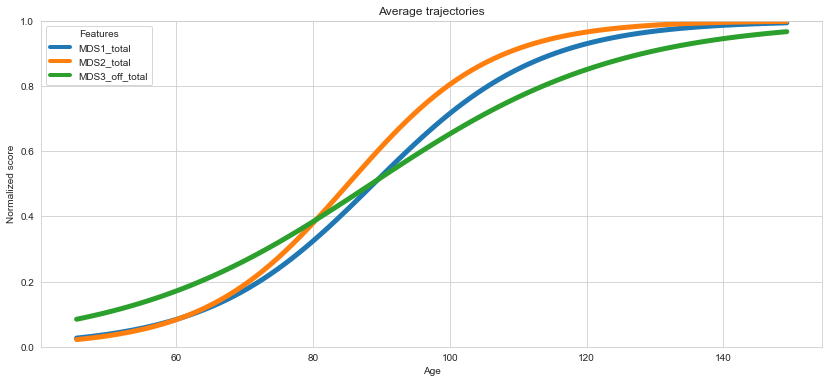

In [21]:
ax = leaspy_plotting.average_trajectory(alpha=1, figsize=(14,6), n_std_left=2, n_std_right=8)
plt.show()

# Part V : Personalize the model to individual data

<span style='color: #015e75; font-weight: 600;'>ℹ️ Information ℹ️</span> The personalization procedure allows to estimate the individual parameters that allows to modify the average progression to individual observations. The variations from the average trajectory to the individual one are encoded within three individual parameters :
- $\alpha_i = \exp(\xi_i)$ : the acceleration factor, that modulates the speed of progression : $\alpha_i > 1$ means faster, $\alpha_i < 1$ means slower than the average progression
- $\tau_i$ : the time shift which delays the progression in a given number of years. It has to be compared to  `tau_mean` $ = \bar{\tau} $  which is in the model parameters above. In fact, $ \tau_i \sim \mathcal{N}( \bar{\tau}, \sigma_{\tau}^2)$ , so $\tau_i > \bar{\tau}$ means that the patient has a disease that starts later than average, while $\tau_i < \bar{\tau}$ means that the patient has a disease that starts earlier than average
- $w_i = (w_1, ..., w_N)$ ($N$ being the number of features) : the space-shift which might, for a given individual, change the ordering of the conversion of the different features, compared to the mean trajectory.

In a nutshell, the $k$-th feature at the $j$-th visit of subject $i$, which occurs at time $t_{ij}$ writes:

$$y_{ijk} = f_\theta ( w_{ik}+ \exp(\xi_i) * (t_{ij} - \tau_i) ) + \epsilon_{ijk}$$

With:
- $\theta$ being the population parameters, inferred during calibration of the model,
- $f_\nu$ a parametric family of trajectories depending of model type,
- $\epsilon_{ijk}$ an independent normally distributed error term.

This writing is not exactly correct but helps understand the role of each individual parameters.

**[ Advanced ]** Remember the `sources`, or the `source_dimension`? Well, $w_i$ is not estimated directly, but rather thanks to a Independent Component Analysis, such that $w_i = A s_i$ where $s_i$ is of dimension $N_s$ = `source_dimension`. See associated papers for further details.

Now, let's estimate these individual parameters. The procedure relies on the `scipy_minimize` algorithm (gradient descent) that you have to define (or to load from an appropriate json file) :

<span style='color: #a13203; font-weight: 600;'>💬 Question 19 💬</span> __First set the parameters__

In [22]:
settings_personalization = AlgorithmSettings('scipy_minimize', seed=0)

<span style='color: #a13203; font-weight: 600;'>💬 Question 20a 💬</span> __Then use the second most important function of leaspy : `leaspy.personalize`. It estimates the individual parameters for the data you provide:__

In [23]:
?leaspy.personalize

In [24]:
ip = leaspy.personalize(data_test, settings_personalization)

 ==> Setting seed to 0
|########################################|   40/40 subjects
Personalize with `scipy_minimize` took: 1s
The standard deviation of the noise at the end of the personalize is:
MDS1_total: 4.66%
MDS2_total: 4.92%
MDS3_off_total: 5.84%


<span style='color: #015e75; font-weight: 600;'>ℹ️ Information ℹ️</span> Note here that you can personalize your model on patients that have only one visit! And you don't have to use the same `data` as previously. It is especially useful, and important, in order to validate your model!

<span style='color: #a13203; font-weight: 600;'>💬 Question 20b 💬</span> __Once the personalization is done, check the different functions that the `IndividualParameters` provides (you can save and load them, transform them to dataframes, etc) :__

In [25]:
?ip

<span style='color: #a13203; font-weight: 600;'>💬 Question 21 💬</span> __Plot the test data, but with reparametrized ages instead of real ages__

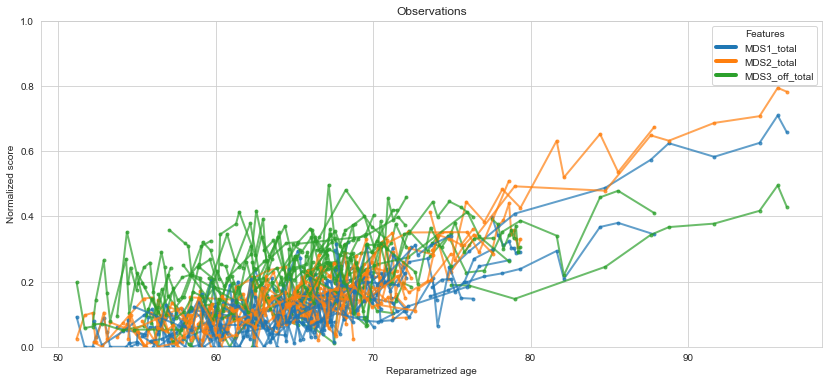

In [26]:
# Plot the test data with individually reparametrized ages
ax = leaspy_plotting.patient_observations_reparametrized(data_test, ip,
                                                         alpha=.7, linestyle='-',
                                                         #patients_idx=list(data_test.individuals.keys())[:4],
                                                         figsize=(14, 6))
plt.show()

Remember the raw plotting of values during question 9? Better, no?

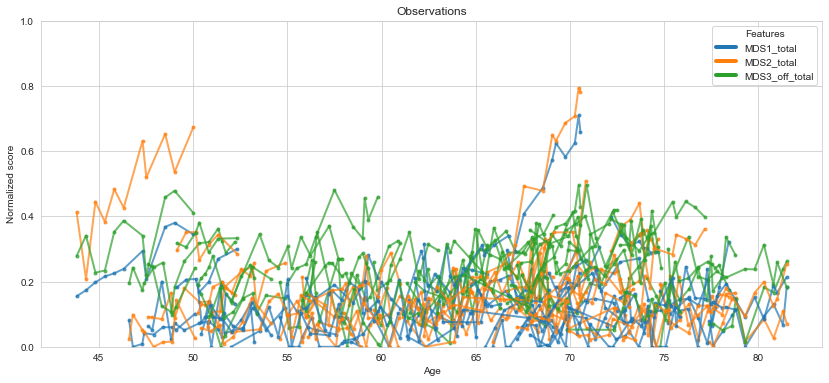

In [27]:
# Plot the test data with individually with true ages
ax = leaspy_plotting.patient_observations(data_test,
                                          alpha=.7, linestyle='-',
                                          #patients_idx=list(data_test.individuals.keys())[:4],
                                          figsize=(14, 6))
plt.show()

Now, let's see what you can do with the individual parameters.

# Part VI : Impute missing values & predict individual trajectories

<span style='color: #015e75; font-weight: 600;'>ℹ️ Information ℹ️</span> Together with the population parameters, the individual parameters entirely defines the individual trajectory, and thus, the biomarker values at any time. So you can reconstruct the individual biomarkers at different ages.

You can reconstruct your observations at seen ages, i.e. at visits that have been used to personalize the model. There are two reasons you might want to do that:
- see how well the model fitted individual data
- impute missing values: as Leaspy handles missing values, it can then reconstruct them (note that this reconstruction will be noiseless)


The third very important function - after `leaspy.fit` and `leaspy.personalize` - is `leaspy.estimate`. Given some individual parameters and timepoints, the function estimates the values of the biomarkers at the given timepoints which derive from the individual trajectory encoded thanks to the individual parameters.

<span style='color: #a13203; font-weight: 600;'>💬 Question 22 💬</span> __Check out the documentation__

In [28]:
?leaspy.estimate

<span style='color: #a13203; font-weight: 600;'>💬 Question 23 💬</span> __Before running `leaspy.estimate`, let's first retrieve the observations of subject 'GS-187' in the initial dataset. Get also his/her individual parameters as shown here:__

In [29]:
observations = df_test.loc['GS-187']
print(f'Seen ages: {observations.index.values}')
print("Individual Parameters : ", ip['GS-187'])

Seen ages: [61.34811783 62.34811783 63.84811783 64.34812164 67.84812164 68.34812164
 69.34812164 69.84812164 70.84812164 71.34812164 71.84812164 72.34812164
 72.84812164 73.34812164]
Individual Parameters :  {'xi': 0.01895267702639103, 'tau': 72.0159912109375, 'sources': [-1.349053144454956, 0.1018250584602356]}


<span style='color: #015e75; font-weight: 600;'>ℹ️ Information ℹ️</span> The `estimate` first argument is a dictionary, so that you can estimate the trajectory of multiple individuals simultaneously (as long as the individual parameters of all your queried patients are in `ip`.

<span style='color: #a13203; font-weight: 600;'>💬 Question 24 💬</span> __Now, let's estimate the trajectory for this patient.__

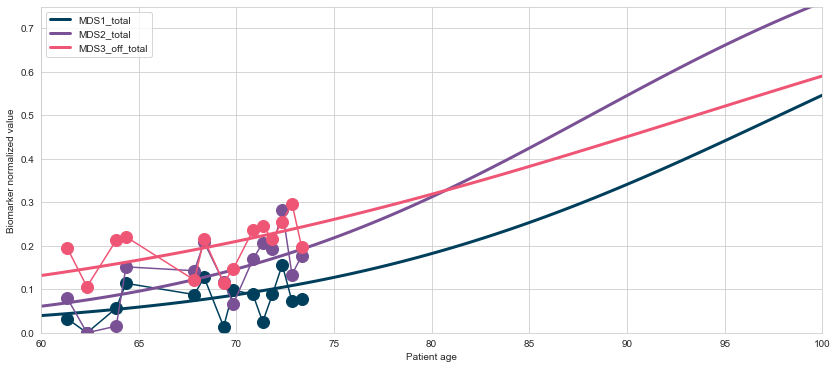

In [30]:
timepoints = np.linspace(60, 100, 100)
reconstruction = leaspy.estimate({'GS-187': timepoints}, ip)

def plot_trajectory(timepoints, reconstruction, observations=None):

    if observations is not None:
        ages = observations.index.values

    plt.figure(figsize=(14, 6))
    plt.ylim(0, .75)
    plt.ylabel('Biomarker normalized value')
    plt.xlim(60, 100)
    plt.xlabel('Patient age')
    colors = ['#003f5c', '#7a5195', '#ef5675', '#ffa600']

    for c, name, val in zip(colors, leaspy.model.features, reconstruction.T):
        plt.plot(timepoints, val, label=name, c=c, linewidth=3)
        if observations is not None:
            plt.plot(ages, observations[name], c=c, marker='o', markersize=12)

    plt.legend()
    plt.show()

plot_trajectory(timepoints, reconstruction['GS-187'], observations)

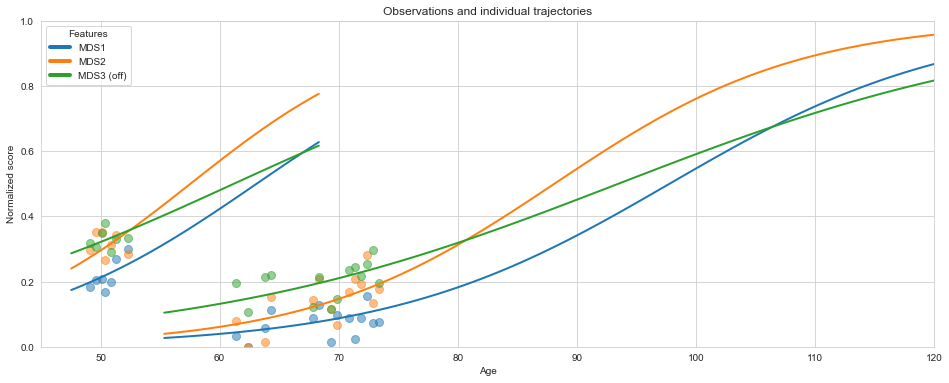

In [31]:
# Or with plotting object
ax = leaspy_plotting.patient_trajectories(data_test, ip,
                                          patients_idx=['GS-187','GS-180'],
                                          labels=['MDS1','MDS2', 'MDS3 (off)'],
                                          #reparametrized_ages=True, # check sources effect

                                          # plot kwargs
                                          #color=['#003f5c', '#7a5195', '#ef5675', '#ffa600'],
                                          alpha=1, linestyle='-', linewidth=2,
                                          #marker=None,
                                          markersize=8, obs_alpha=.5, #obs_ls=':',
                                          figsize=(16, 6),
                                          factor_past=.5,
                                          factor_future=5, # future extrapolation
                                          )
#ax.set_ylim(0, .75)
ax.set_xlim(45, 120)
plt.show()

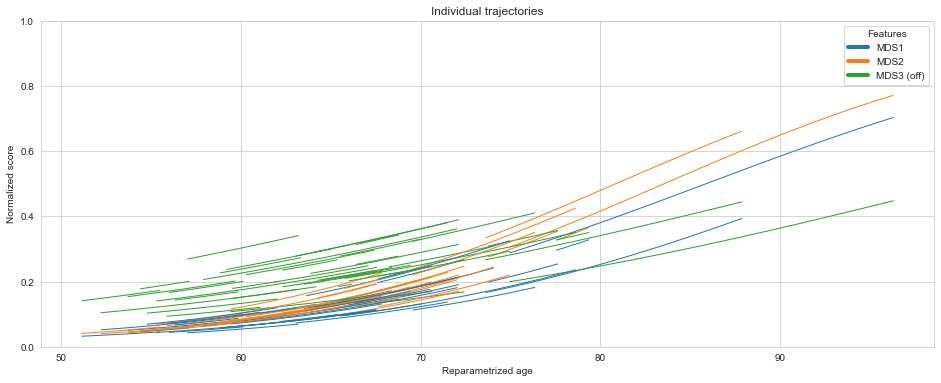

In [32]:
# Grasp source effects
ax = leaspy_plotting.patient_trajectories(data_test, ip,
                                          patients_idx='all',
                                          labels=['MDS1','MDS2', 'MDS3 (off)'],
                                          reparametrized_ages=True, # check sources effect

                                          # plot kwargs
                                          alpha=1, linestyle='-', linewidth=1,
                                          marker=None,
                                          figsize=(16, 6),
                                          factor_past=0,
                                          factor_future=0, # no extrapolation (future) nor past
                                          )
#ax.set_ylim(0, .75)
#ax.set_xlim(45, 120)
plt.show()

# Part VII : Leaspy application - Cofactor analysis

<span style='color: #015e75; font-weight: 600;'>ℹ️ Information ℹ️</span> Besides prediction, the individual parameters are interesting in the sense that they provide meaningful and interesting insights about the disease progression. For that reason, these individual parameters can be correlated to other cofactors. Let's consider that you have a covariate _Cofactor 1_ that encodes a genetic status: 1 if a specific mutation is present, 0 otherwise.

<span style='color: #a13203; font-weight: 600;'>💬 Question 25 💬</span> __Now, let's see if this mutation has an effect on the disease progression:__

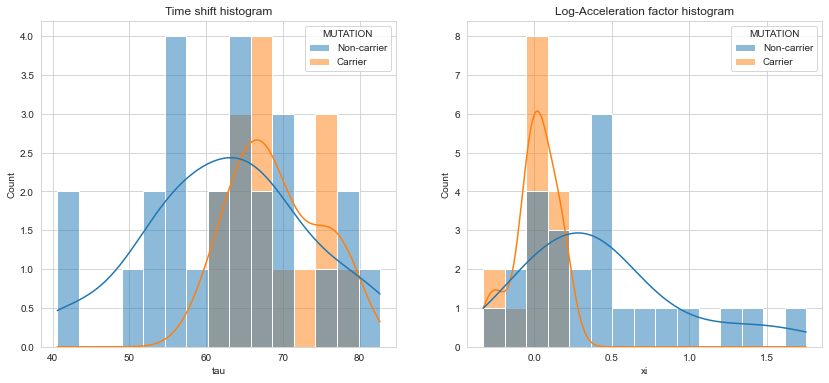

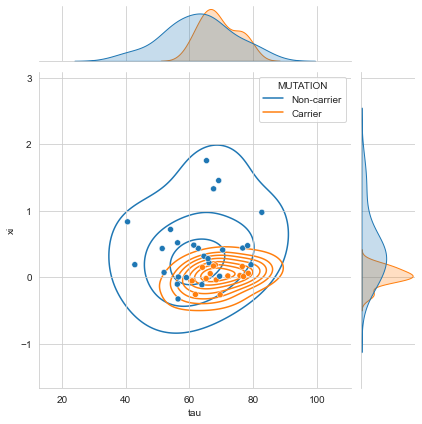

In [33]:
import seaborn as sns

# —— Convert individual parameters to dataframe
df_ip = ip.to_dataframe()

# —— Join the cofactors to individual parameters
cofactor = pd.read_csv(data_path('cof_leaspy1.csv'), index_col=['ID'])
df_ip = df_ip.join(cofactor.replace({'MUTATION':{0: 'Non-carrier', 1: 'Carrier'}}))

_, ax = plt.subplots(1, 2, figsize=(14, 6))

# —— Plot the time shifts in carriers and non-carriers
ax[0].set_title('Time shift histogram')
sns.histplot(data=df_ip, x='tau', hue='MUTATION', bins=15, ax=ax[0], stat='count', common_norm=False, kde=True)

# —— Plot the acceleration factor in carriers and non-carriers
ax[1].set_title('Log-Acceleration factor histogram')
sns.histplot(data=df_ip, x='xi', hue='MUTATION', bins=15, ax=ax[1], stat='count', common_norm=False, kde=True)

plt.show()

# __ Joint density (tau, xi) __
g = sns.jointplot(data=df_ip, x="tau", y="xi", hue="MUTATION", height=6)
g.plot_joint(sns.kdeplot, zorder=0, levels=8, bw_adjust=1.5);

 <span style='color: #a13203; font-weight: 600;'>💬 Question 26 💬</span> __Now, check your hypothesis with statistical tests__

In [34]:
# Shortcuts of df_ip for 2 sub-populations
carriers = df_ip[df_ip['MUTATION'] == 'Carrier']
non_carriers = df_ip[df_ip['MUTATION'] == 'Non-carrier']
# —— Student t-test (under the assumption of a gaussian distribution only)
print(stats.ttest_ind(carriers['tau'], non_carriers['tau']))
print(stats.ttest_ind(carriers['xi'], non_carriers['xi']))

# —— Mann-Withney t-test
print(stats.mannwhitneyu(carriers['tau'], non_carriers['tau']))
print(stats.mannwhitneyu(carriers['xi'], non_carriers['xi']))

# Do you think to other approaches for testing your hypothesis?

Ttest_indResult(statistic=2.1543281658112354, pvalue=0.037618725549280425)
Ttest_indResult(statistic=-3.180184315953275, pvalue=0.002927223112548619)
MannwhitneyuResult(statistic=260.0, pvalue=0.04427485971006442)
MannwhitneyuResult(statistic=71.0, pvalue=0.0011922966511528077)


In [35]:
# Other approach: multivariate logistic regression to predict mutation from individual parameters
import statsmodels.formula.api as smf
from sklearn.metrics import roc_auc_score

df_ip_encoded = df_ip.replace({'MUTATION': {'Non-carrier': 0, 'Carrier': 1}})

indiv_params_names = df_ip_encoded.drop(columns='MUTATION').columns.tolist()
classif = smf.logit(f'MUTATION ~ {" + ".join(indiv_params_names)}',
                    data=df_ip_encoded, missing='raise')
classif = classif.fit() # or .fit_regularized(method='l1') [~ same results here]

roc_auc = roc_auc_score(df_ip_encoded['MUTATION'], classif.predict(df_ip_encoded))
print(f'\nROC-AUC score = {roc_auc:.1%}')

classif.summary()

Optimization terminated successfully.
         Current function value: 0.373202
         Iterations 8

ROC-AUC score = 88.8%


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               MUTATION   No. Observations:                   40
Model:                          Logit   Df Residuals:                       35
Method:                           MLE   Df Model:                            4
Date:                Tue, 11 Jan 2022   Pseudo R-squ.:                  0.4359
Time:                        12:44:07   Log-Likelihood:                -14.928
converged:                       True   LL-Null:                       -26.463
Covariance Type:            nonrobust   LLR p-value:                 0.0001227
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -12.6314      5.562     -2.271      0.023     -23.532      -1.731
xi            -7.8339      2.877     -2.723      0.006     -13.472      -2.196
tau            0.1986      0.085      2.326      0.020       0.031       0.366
sources_0      0.6167      0.843      0.732      0.464      -1.035       2.269
sources_1     -0.2332      0.590     -0.395      0.693      -1.389       0.922
==============================================================================
"""

# Part VIII : Data Simulation

<span style='color: #015e75; font-weight: 600;'>ℹ️ Information ℹ️</span> Now that you are able to predict the evolution of a patient and use it to analyse cofactors, you might want to simulate a new one thanks to the information that you have learned. To do so you can use the last method of leaspy that we will study : `simulate`.

<span style='color: #a13203; font-weight: 600;'>💬 Question 27 💬</span> __Have a look to the function__

In [36]:
?leaspy.simulate

<span style='color: #015e75; font-weight: 600;'>ℹ️ Information ℹ️</span> To use the function we will first extract the individual parameters using personalize with `mode_real` option. The simulate function learns the joined distribution of the individual parameters and baseline age of the subjects
present in ``individual_parameters`` and ``data`` respectively to sample new patients from this joined distribution.

<span style='color: #a13203; font-weight: 600;'>💬 Question 28 💬</span> __Define the settings for the personalization and get the individual parameters__

In [37]:
settings_ip_simulate = AlgorithmSettings('mode_real', seed=0)
individual_params = leaspy.personalize(data_test, settings_ip_simulate)

 ==> Setting seed to 0

Personalize with `mode_real` took: 3s
The standard deviation of the noise at the end of the personalize is:
MDS1_total: 4.69%
MDS2_total: 4.93%
MDS3_off_total: 5.90%


<span style='color: #a13203; font-weight: 600;'>💬 Question 29 💬</span> __Define your algorithm for the simulation and simulate individuals from previously obtained individual parameters and dataset__

In [38]:
# You can tweak many parameters for the simulation, cf. the full reference: https://leaspy.readthedocs.io/en/latest/generated/leaspy.algo.simulate.simulate.SimulationAlgorithm.html
settings_simulate = AlgorithmSettings('simulation', seed=0)
simulated_data = leaspy.simulate(individual_params, data_test, settings_simulate)

 ==> Setting seed to 0

Simulate with `simulation` took: 0s
The standard deviation of the noise at the end of the simulate is:
MDS1_total: 4.69%
MDS2_total: 4.93%
MDS3_off_total: 5.90%


<span style='color: #a13203; font-weight: 600;'>💬 Question 30 💬</span> __Access to the individual parameters of one individual that you have created__

In [39]:
print(simulated_data.get_patient_individual_parameters("Generated_subject_001"))

{'tau': tensor([55.3969], dtype=torch.float64), 'xi': tensor([0.9163], dtype=torch.float64), 'sources': tensor([-1.1907,  1.4104], dtype=torch.float64)}


<span style='color: #a13203; font-weight: 600;'>💬 Question 31 💬</span> __Plot the joint distribution of individual parameters (tau, xi) for simulated individuals that you have created__

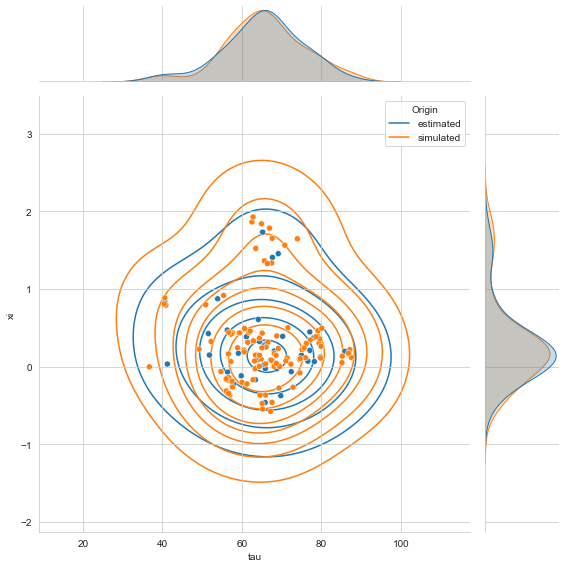

In [40]:
# Create a dataframe with individual parameters from both real & simulated individuals
df_ip_both = pd.concat({
    'estimated': individual_params.to_dataframe(),
    'simulated': simulated_data.get_dataframe_individual_parameters()
}, names=['Origin'])

g = sns.jointplot(data=df_ip_both, x='tau', y='xi', hue='Origin', height=8,
                  marginal_kws=dict(common_norm=False))
g.plot_joint(sns.kdeplot, zorder=0, levels=8, bw_adjust=2.);

<span style='color: #a13203; font-weight: 600;'>💬 Question 32 💬</span> __Plot some simulated individual trajectories__

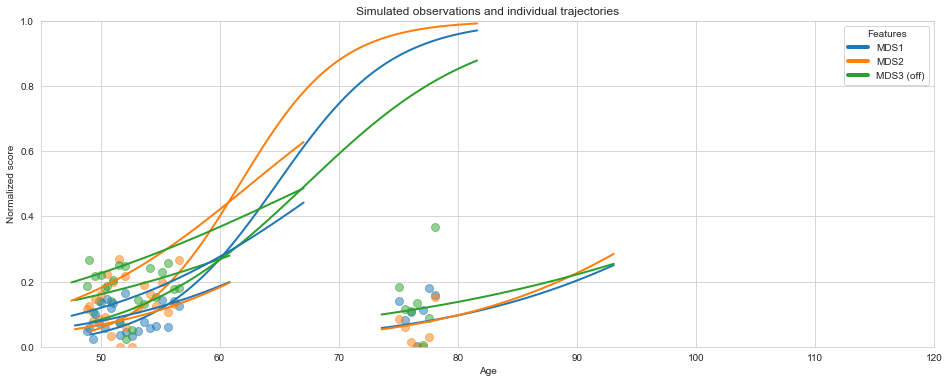

In [41]:
# Or with plotting object
ax = leaspy_plotting.patient_trajectories(simulated_data.data,
                                          IndividualParameters().from_dataframe(simulated_data.get_dataframe_individual_parameters()),
                                          patients_idx=[f'Generated_subject_{i:03}' for i in [1,2,7,42]],
                                          labels=['MDS1','MDS2', 'MDS3 (off)'],
                                          #reparametrized_ages=True, # check sources effect

                                          # plot kwargs
                                          #color=['#003f5c', '#7a5195', '#ef5675', '#ffa600'],
                                          alpha=1, linestyle='-', linewidth=2,
                                          #marker=None,
                                          markersize=8, obs_alpha=.5, #obs_ls=':',
                                          figsize=(16, 6),
                                          factor_past=.5,
                                          factor_future=5, # future extrapolation
                                          )
ax.set_title("Simulated observations and individual trajectories")
#ax.set_ylim(0, .75)
ax.set_xlim(45, 120)
plt.show()

# Congratulations this is the end !!!!!

You can now have a break ;)